In [1]:
import sys
sys.path.append("/home/jzh/data_jzh/pints_related/gits_2/pySDC")
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import statistics
import pySDC.helpers.plot_helper as plt_helper
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.projects.DAE.problems.ThreeInverterSystem import ThreeInverterSystem
from pySDC.projects.DAE.problems.WSCC9BusSystem_noSE import WSCC9BusSystem

from pySDC.projects.DAE.sweepers.fully_implicit_DAE import fully_implicit_DAE
from pySDC.projects.DAE.sweepers.Runge_Kutta_DAE import BackwardEulerDAE, ImplicitMidpointMethodIMEXDAE, DIRK43_2DAE, TrapezoidalRuleDAE, EDIRK4_DAE

# from pySDC.projects.DAE.misc.HookClass_DAE import approx_solution_hook
# from pySDC.projects.DAE.misc.HookClass_DAE import error_hook
from pySDC.implementations.hooks.log_solution import LogSolution

from pySDC.helpers.stats_helper import get_sorted
from pySDC.helpers.stats_helper import filter_stats



In [2]:
class TimeSeries:
    """Stores data from different simulation sources.
        A TimeSeries object always consists of timestamps and datapoints.
    """
    def __init__(self, name, time, values, label=""):
        self.time = np.array(time)
        self.values = np.array(values)
        self.name = name
        if not label:
            self.label = name
        else:
            self.label = label
    
    def __mul__(self, ts):
        if isinstance(ts, TimeSeries):
            new_val = self.values * ts.values
        else:
            new_val = self.values * ts
        return TimeSeries(self.name+"_mul", self.time, new_val)
    
    def abs(self):
        """ Calculate absolute value of complex time series.
        """
        abs_values = []
        for value in self.values:
            abs_values.append(np.abs(value))
        ts_abs = TimeSeries(self.name+'_abs', self.time, abs_values, self.label+'_abs')
        return ts_abs

    def phase(self):
        """ Calculate phase of complex time series.
        """
        phase_values = []
        for value in self.values:
            phase_values.append(np.angle(value, deg=True))
        ts_phase = TimeSeries(self.name+'_phase', self.time, phase_values, self.label+'_phase')
        return ts_phase

    @staticmethod
    def rel_diff(name, ts1, ts2, normalize = None, point_wise = False, threshold = 0):
        """
        Returns relative difference between two time series objects to the first.
        calculated against the max of ts1.
        """
        diff_ts = TimeSeries.diff('diff', ts1, ts2)
        diff_val=diff_ts.values
        if normalize is not None:
            rel_diff_to_ts1 = diff_val/normalize
            ts_rel_diff_to_ts1 = TimeSeries(name, diff_ts.time, rel_diff_to_ts1)
            return ts_rel_diff_to_ts1
        # relative error to the max value of ts1
        if not point_wise:
            rel_diff_to_ts1 = diff_val/np.abs(ts1.values).max()
            ts_rel_diff_to_ts1 = TimeSeries(name, diff_ts.time, rel_diff_to_ts1)
        else:
            # calculate the relative point-wise error above threshold 
            index_=np.where(np.abs(ts1.values)>threshold)
            ts1_filtered_val_=ts1.values[index_]
            ts1_filtered_time_=ts1.time[index_]
            #ts2_filtered_val_=ts2.values[index_]
            diff_val_filtered=diff_val[index_]
            rel_diff_to_ts1 = diff_val_filtered/ts1_filtered_val_
            ts_rel_diff_to_ts1 = TimeSeries(name, ts1_filtered_time_, np.abs(rel_diff_to_ts1))
        return ts_rel_diff_to_ts1
    
    @staticmethod
    def diff(name, ts1, ts2):
        """Returns difference between values of two Timeseries objects.
        """
        if len(ts1.time) == len(ts2.time):
            ts_diff = TimeSeries(name, ts1.time, (ts1.values - ts2.values))
        else:  # different timestamps, common time vector and interpolation required before substraction
            time = sorted(set(list(ts1.time) + list(ts2.time)))
            interp_vals_ts1 = np.interp(time, ts1.time, ts1.values)
            interp_vals_ts2 = np.interp(time, ts2.time, ts2.values)
            ts_diff = TimeSeries(name, time, (interp_vals_ts2 - interp_vals_ts1))
        return ts_diff

    @staticmethod
    def abs_rel_diff(name, ts1, ts2, normalize = None, point_wise = False, threshold = 0):
        ts_rel_diff = TimeSeries.rel_diff(name, ts1, ts2, normalize, point_wise, threshold)
        ts_rel_diff.values = np.abs(ts_rel_diff.values)
        return ts_rel_diff


## Load Simulation Results

In [3]:
res_candidates_Vn0 = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[]
}


# dq values are still 2d array, not mapped to complex until calculating the error later!
res_candidates_Vn0[0] = pickle.load(open("data/pintsime2/wscc09_DIRK43_2DAE_ts.p", 'rb'))
res_candidates_Vn0[1] = pickle.load(open("data/pintsime2/wscc09_ImplicitMidpointMethodIMEXDAE_ts.p", 'rb'))
res_candidates_Vn0[2] = pickle.load(open("data/pintsime2/wscc09_fully_implicit_DAE_ts.p", 'rb'))
res_candidates_Vn0[3] = pickle.load(open("data/pintsime2/wscc09_TrapezoidalRuleDAE_2DAE_ts.p", 'rb'))
res_candidates_Vn0[4] = pickle.load(open("data/pintsime2/wscc09_EDIRK4_DAE_ts.p", 'rb'))
res_candidates_Vn0[5] = pickle.load(open("data/pintsime2/wscc09_BackwardEulerDAE_ts.p", 'rb'))


In [4]:
reference_res = pickle.load(open("data/pintsime2/wscc09_reference_eb_1us_ts.p", 'rb'))


In [5]:
reference_res.values

array([1.00000000e+00, 9.99997127e-01, 9.99934795e-01, ...,
       3.23242728e+16, 3.23350764e+16, 3.23458799e+16])

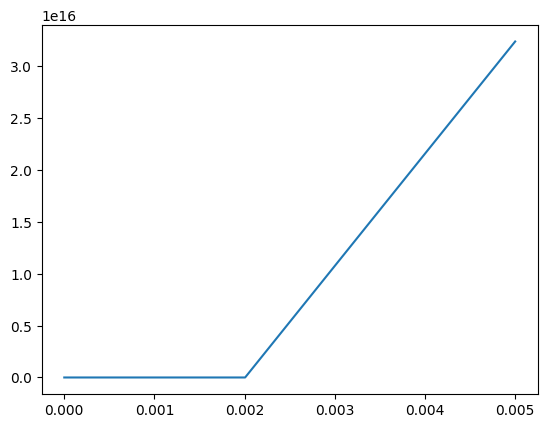

In [6]:
plt.figure(10)
plt.plot(reference_res.time, reference_res.values, label=f"ref")
# plt.xlim(0,0.002)
# plt.ylim(reference_res.values[0],reference_res.values[1000])
plt.show()

## Plots

In [7]:
# dt_list = [100e-6, 200e-6, 250e-6, 500e-6, 1000e-6]
# dt_list = [200e-6, 500e-6, 1000e-6]
dt_list = [500e-6, 1000e-6, 2000e-6]



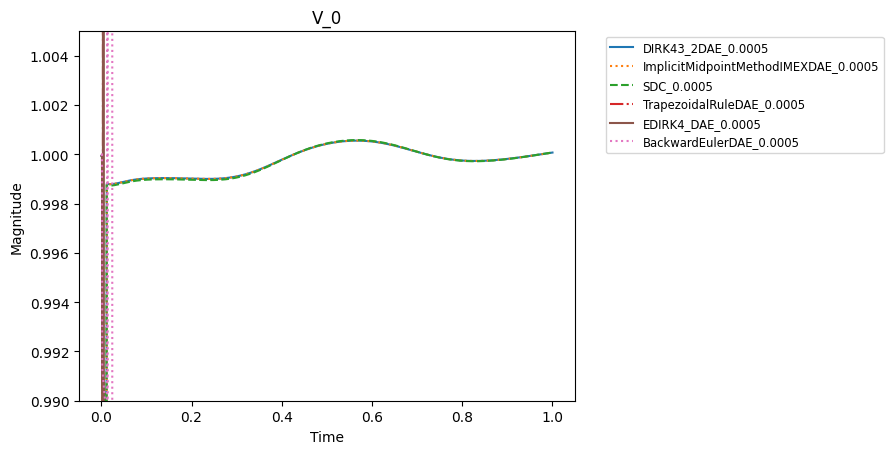

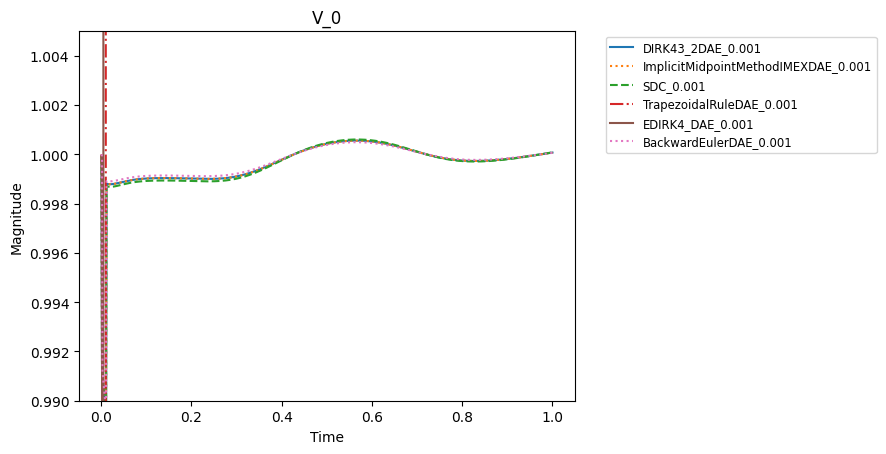

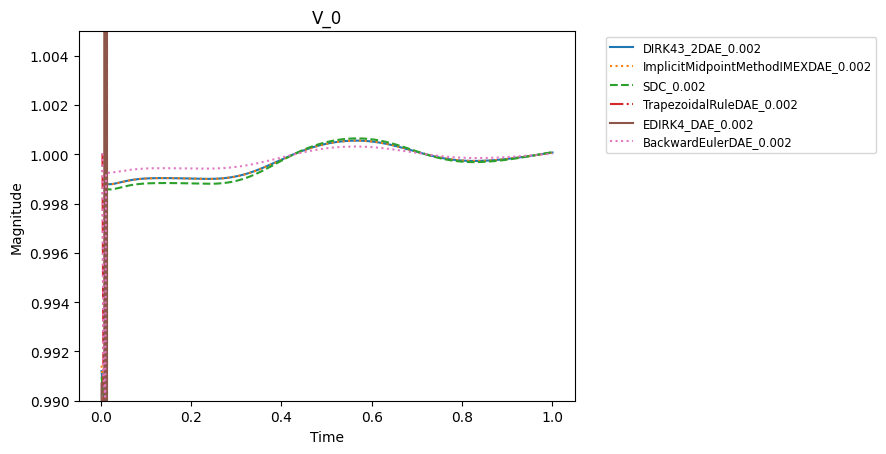

In [15]:
method_list_str = ['DIRK43_2DAE', 'ImplicitMidpointMethodIMEXDAE', 'SDC','TrapezoidalRuleDAE', 'EDIRK4_DAE', 'BackwardEulerDAE']
line_styles = ['solid', 'dotted', 'dashed', 'dashdot','solid', 'dotted']
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:pink']



# plt.plot(reference_res.time, reference_res.values, label=f"ref")
for dt_idx in range(len(dt_list)):
    plt.figure(dt_idx)
    # plt.plot(reference_res.time, reference_res.values, label=f"ref")
    for key, val in res_candidates_Vn0.items():
        # if(abs(res_candidates_dq[key][dt_idx].values[-1]) > 1e2):
        #     continue
        # val[res_dt_idx].values = np.vectorize(complex)(val[dt_idx].values[:,0], val[dt_idx].values[:,1])
        plt.plot(res_candidates_Vn0[key][dt_idx][0].time, res_candidates_Vn0[key][dt_idx][0].values, linestyle = line_styles[key], color=colors[key], label=f"{method_list_str[key]}_{dt_list[dt_idx]}")
    # plt.legend()
    legend_labels = [f"{method_list_str[key]}_{dt_list[dt_idx]}" for key in res_candidates_Vn0]
    plt.legend(labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.ylim(0.99,1.005)

    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.title("V_0")

plt.show()


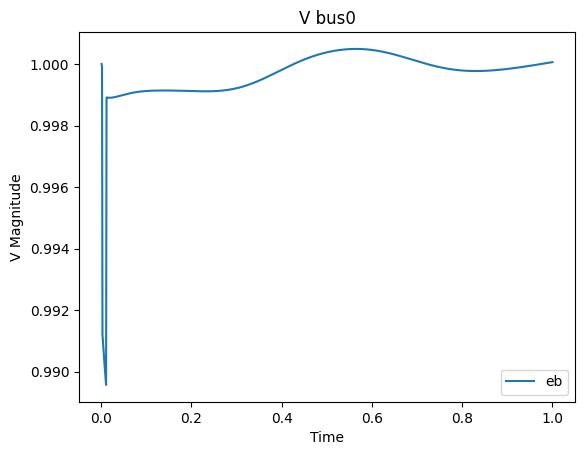

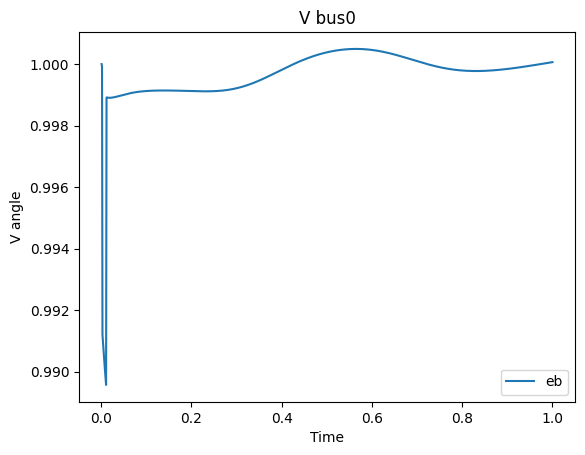

In [18]:

plt.figure(10)
dt_idx = 1
# plt.plot(res_candidates_Vn0[0][dt_idx][0].time, res_candidates_Vn0[0][dt_idx][0].values, label=f"DIRK43")
# plt.plot(res_candidates_Vn0[1][dt_idx][0].time, res_candidates_Vn0[1][dt_idx][0].values, label=f"MidPointIMEX")
# plt.plot(res_candidates_Vn0[2][dt_idx][0].time, res_candidates_Vn0[2][dt_idx][0].values, label=f"sdc")
# plt.plot(res_candidates_Vn0[3][dt_idx][0].time, res_candidates_Vn0[3][dt_idx][0].values, label=f"trapez")
plt.plot(res_candidates_Vn0[5][dt_idx][0].time, res_candidates_Vn0[5][dt_idx][0].values, label=f"eb")
# plt.xlim(0.0,0.2)
# plt.ylim(reference_res.values[0],reference_res.values[1000])
plt.legend()
plt.xlabel("Time")
plt.ylabel("V Magnitude")
plt.title("V bus0")

plt.show()

plt.figure(11)
dt_idx = 1
# plt.plot(res_candidates_Vn0[0][dt_idx][0].time, res_candidates_Vn0[0][dt_idx][0].values, label=f"DIRK43")
# plt.plot(res_candidates_Vn0[1][dt_idx][0].time, res_candidates_Vn0[1][dt_idx][0].values, label=f"MidPointIMEX")
# plt.plot(res_candidates_Vn0[2][dt_idx][1].time, res_candidates_Vn0[2][dt_idx][1].values, label=f"sdc")
# plt.plot(res_candidates_Vn0[3][dt_idx][0].time, res_candidates_Vn0[3][dt_idx][0].values, label=f"trapez")
plt.plot(res_candidates_Vn0[5][dt_idx][0].time, res_candidates_Vn0[5][dt_idx][0].values, label=f"eb")
# plt.xlim(0.0,0.2)
# plt.ylim(reference_res.values[0],reference_res.values[1000])
plt.legend()
plt.xlabel("Time")
plt.ylabel("V angle")
plt.title("V bus0")

plt.show()

In [10]:
res_candidates_Vn0[2][dt_idx]

(<__main__.TimeSeries at 0x7f62382fcf40>,
 <__main__.TimeSeries at 0x7f60d35bb7c0>)